# Defining "complicated" state-space models
Some users reported difficulties with definining "complicated" state-space models, that is models where the distribution of $X_t|X_{t-1}$ or $Y_t|X_t$ may: 
* be multivariate;
* involve non-standard distributions; 
* involve "named" variables (such as "S" /"I" / "R" for the number of susceptible / infected / recovered cased in a SIR model), and the user would like the specify the model accordingly. 

This tutorial explains how to deal with such issues.

## Before we start

Note that if you are only interested in implementing the bootstrap filter associated to your model, and if the following tasks are easy to implement:
* writing a simulator that samples ($N$ times) from the distribution of $X_0$, and $X_t$ given $X_{t-1}$;
* writing a function that computes the log of density $f(y_t|x_t)$ of data-point $y_t$ given $X_t=x_t$, for an array of $N$ particles $X_t^n$;

then one option is to implement manually the corresponding Feynman-Kac object that describes that bootstrap filter. See the previous [tutorial](Defining_Feynman-Kac_models_manually.html). 

## Multivariate state-space models (with conditional independent distributions)

The bearings-only model is a famous (toy) tracking model. The tracked object (e.g. a ship) moves according to a 2D motion model, where the speed evolves according to a random walk. State $(X_t)$ is 4-dimensional, the first two components gives the position, the next two gives the velocity, and one has:
$$ X_t = \begin{pmatrix} I_2 & I_2 \\ 0_2 & I_2 \end{pmatrix} X_{t-1} + 
\begin{pmatrix} 0_2 & 0_2 \\ 0_2 & U_t \end{pmatrix},\qquad U_t \sim N_2\left(0_2, \sigma_X^2 I_2\right).$$

Note in particular that the first two components (the position in Cartesian coordinates) are **deterministic** functions of $X_{t-1}$. 

Furthermore, ones observes some radar measurement, that gives the **direction** (angle) of that object, up to some noise:
$$ Y_t = \mathrm{atan}\left( \frac{X_t[1]}{X_t[2]} \right) + V_t,\qquad V_t \sim N(0,\sigma_Y^2).$$

Here how you may define such a model; pay particular attention to method `PX`.

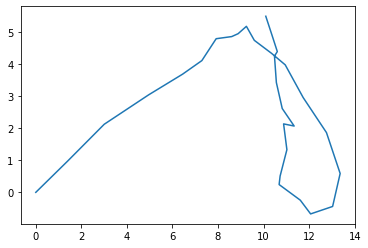

In [30]:
from matplotlib import pyplot as plt

from particles import distributions as dists
from particles import state_space_models as ssms

class BearingsOnly(ssms.StateSpaceModel):
    """ Bearings-only tracking SSM.

    """
    default_params = {'sigmaX': 2.e-4, 
                      'sigmaY': 1e-3,
                      'x0': np.array([3e-3, -3e-3, 1., 1.])
                     }

    def PX0(self):
        return dists.IndepProd(dists.Dirac(loc=self.x0[0]),
                               dists.Dirac(loc=self.x0[1]),
                               dists.Normal(loc=self.x0[2], scale=self.sigmaX),
                               dists.Normal(loc=self.x0[3], scale=self.sigmaX),
                               )

    def PX(self, t, xp):
        return dists.IndepProd(dists.Dirac(loc=xp[:, 0] + xp[:, 2]),
                               dists.Dirac(loc=xp[:, 1] + xp[:, 3]),
                               dists.Normal(loc=xp[:, 2], scale=self.sigmaX),
                               dists.Normal(loc=xp[:, 3], scale=self.sigmaX),
                               )

    def PY(self, t, xp, x):
        angle = np.arctan(x[:, 0] / x[:, 1])
        angle[x[:, 1] < 0.] += np.pi
        return dists.Normal(loc=angle, scale=self.sigmaY)
    
bear = BearingsOnly(sigmaX=0.5)
x, y = bear.simulate(30)
xarr = np.array(x).squeeze()
plt.plot(xarr[:, 0], xarr[:, 1])

The following points are noteworthy:
* Since the components of $X_t$ are **independent** (conditional on $X_{t-1}$) we are able to specify the distribution of $X_t$ as a **product** of independent distributions, through `dists.IndepProd`. This particular object takes as input an arbitrary number (2 or more) of univariate distributions, and combines then to define a joint distribution. 
* Since the state-space is $\mathbb{R}^4$, the particles will be stored in a numpy array of shape (N, 4): e.g. first component will be in `x[:, 0]`. (Recall that python uses zero-based indexing.) 
* The probability distributions implemented in `particles` "operate on arrays": whenever a parameter of that distribution varies accross particles, one should specify that parameter as an array. For instance, when we want to specify that 
$$ X_t[3] | X_{t-1} \sim N(X_{t-1}[3], \sigma_X^2)$$
we must define a Gaussian distribution, where the mean (parameter `loc`) is set to `xp[:, 2]`, the array that contains the $N$ possible values of component $X_{t-1}[3]$.


## Non-independent joint distribution, named components

Of course, the big limitation of `dists.IndepProd` is that it does not let you specify joint distributions where components are *not* independent. For this, you may use "structured distributions" (`dists.StructDist`). A nice extra is that it makes it possible to name components. 

Structured distributions were designed initially to specify prior distributions for parameters, but nothing prevent you from using them in the definition of a state-space model. Recall that structured distributions are intimately linked to structured arrays; e.g. when you simulate from a structured distribution, you get a structured array with the same keys. Have a quick look [here](_autosummary/particles.distributions.StructDist.html#particles.distributions.StructDist) if you are not familiar already with structured arrays and structured distributions. 

Here is a silly example: Suppose that you have a state-space model where $X_t=(A_t, B_t)$, and 
\begin{align*}
A_t & \sim N(A_{t-1}, 1) \\
B_t & = B_{t-1} + A_t
\end{align*}

In words, $B_t$ is the cumulative sum of process $A_t$. We may specify a state-space model with such a process as follows:

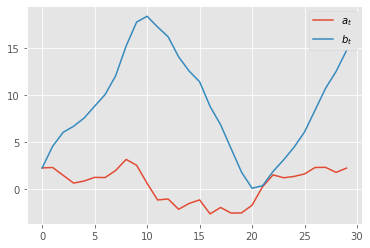

In [45]:
def abdist(xp):  # xp means X_{t-1}
    d = {'a': dists.Normal(loc=xp['a']),
         'b': dists.Cond(lambda x: dists.Dirac(xp['b'] + x['a']))}
    return dists.StructDist(d)

class SillyModel(ssms.StateSpaceModel):
    def PX0(self):
        return abdist({'a': 0., 'b': 0.})
    def PX(self, t, xp):
        return abdist(xp)
    def PY(self, t, xp, x):
        return dists.Normal(loc=x['a'], scale=0.3)  # whatever
    
silly = SillyModel()
x, y = silly.simulate(30)

plt.style.use('ggplot')
plt.plot([xt['a'] for xt in x], label=r'$a_t$')
plt.plot([xt['b'] for xt in x], label=r'$b_t$')
plt.legend()

Let's unpack things:
* `dists.StructDist` takes as input a dict-like object; keys are the names of the components, and values are their distributions.
* Component `'a'` has a certain distribution (here, a Gaussian centred on $A_{t-1}$). 
* Component `'b'` is assigned a **conditional** distribution: the `dists.Cond` object takes as  input a **function**, which for a given input `x`, returns the conditional distribution for that value of `x`. Note the role played `x`: it is a structured array such that `x[f]` returns $N$ value for any component `f` (here `'a'`) whose distribution has already been defined. 
* More generally, you may implement any kind of chain rule decomposition with `StructDist`; e.g; you could introduce a component `c` whose distribution would depend on `a` and `b`, and so on. One important point: these components should defined in order; i.e. if the distribution of `'c'` depends on `'a'` and `'b'`, then `'a'` and `'b'` must be defined previously. 
* Technical point: since Python 3.6, dictionaries preserve order (they remember you defined them with keys ordered in a certain way). If you use an older version of Python, you might need to use ordered dictionary, as explained in the documentation of `StructDist`.

## Arbitrary distributions
With `dists.IndepProd` and `dists.StrucDist` you can create many complicated multivariate distributions out of simple univariate distributions. Many standard univariate distributions are defined in module distributions. Note you can also define many more by using transformations, e.g:

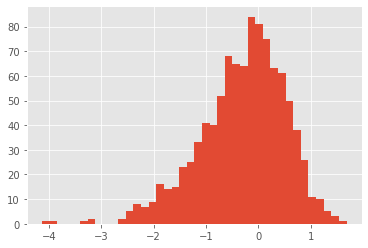

In [42]:
# law of Y=log(X), X~Gamma(2, 2)
dist_log_gam = dists.LogD(dists.Gamma(a=2., b=2.))  
x = dist_log_gam.rvs(size=1000)
plt.hist(x, 40);

Finally, it is always possible to create your **own** (univariate or multivariate) probability distributions, by sub-classing the base class ProbDist; see the documentation of the module for more information.  


## Questions?

This tutorial was written to answer some recurring questions from users; if you feel you are still unable to implement your model, feel free to get in touch with the author of the package. 